In [26]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import yfinance as yf
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [10,5]
plt.style.use('ggplot')  

### Normal Distribution & Risk

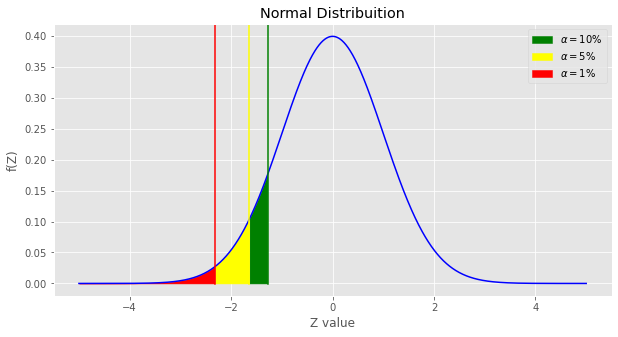

In [72]:
# Dados para o gráfico
mean = 0
std = 1
x = np.linspace(-5, 5, 1000)
y = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-(x - mean)**2 / (2 * std**2))

# Creating graph
plt.plot(x, y, color='blue')

# Filling area 
plt.fill_between(x, y, where=((x < -1.28155)&(x >-1.64485)), color='green', alpha=1,label = r'$\alpha = 10$%')
plt.fill_between(x, y, where=((x <-1.64485)&(x >-2.32635 )), color='yellow', alpha=1,label = r'$\alpha = 5$%')
plt.fill_between(x, y, where=((x < -2.32635)), color='red', alpha=1, label = r'$\alpha = 1$%')

plt.axvline(x = -1.28155, color = 'green',ymin=0.0425)
#plt.text(-1.18155,0.4,'Z=-1.18155')
plt.axvline(x = -1.64485, color = 'yellow',ymin=0.0425)
#plt.text(-1.64485,0.35,'Z=-1.64485')
plt.axvline(x = -2.32635, color = 'red',ymin=0.0425)
#plt.text(-2.32635,0.3,'Z=-2.32635')


plt.xlabel('Z value')
plt.ylabel('f(Z)')
plt.title('Normal Distribuition')
plt.legend()

plt.grid(True)
plt.show()

In [47]:
data_series = pd.DataFrame()
stocks = ['ELET3.SA']
for stock in stocks:
    ticker = yf.Ticker("ELET3.SA")
    serie = ticker.history(period="2y")
    data_series[f'{stock}'] = serie['Open'].values

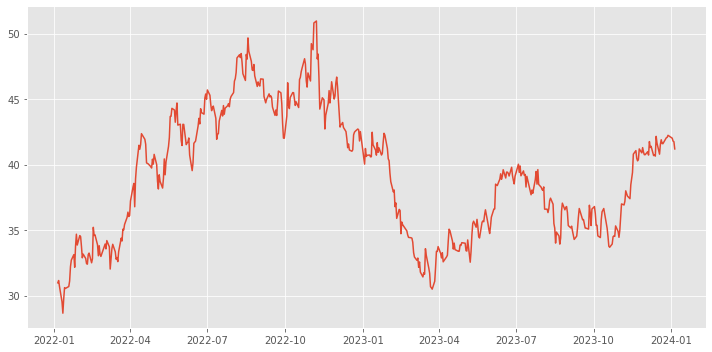

In [52]:
plt.plot(serie.index,data_series['ELET3.SA'])
plt.tight_layout()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BC0B591E10>]],
      dtype=object)

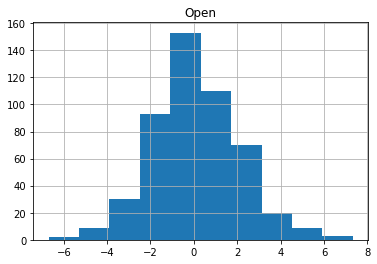

In [6]:
daily_return = data_series[['Open']].pct_change()*100
daily_return.hist(bins = 'sturges')

In [8]:
Price

,Open
Date,
2022-01-05,30.975188
2022-01-06,31.150575
2022-01-07,30.692622
2022-01-10,29.523378
2022-01-11,28.656190
...,...
2023-12-28,42.240002
2024-01-02,42.020000
2024-01-03,41.799999


Text(0.5, 1.0, 'Daily Return Distribution')

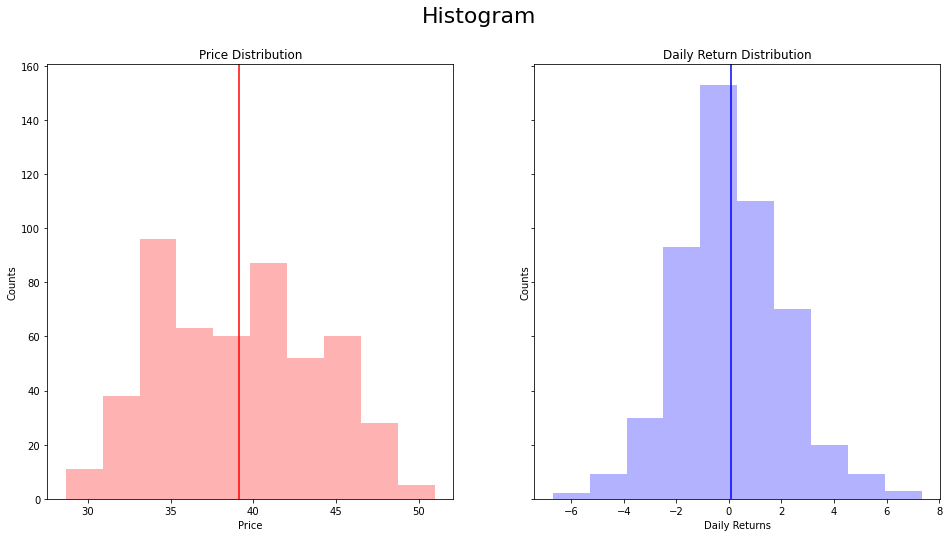

In [12]:
Price = data_series[['Open']]
Daily_return = data_series[['Open']].pct_change()*100


fig, axs = plt.subplots(1,2,figsize = (16,8),sharey = True)

plt.suptitle('Histogram',fontsize = 22)
axs[0].hist(Price['Open'], bins = 'sturges', alpha = 0.3,color = 'red')
axs[0].axvline(Price['Open'].mean(),color = 'red')
axs[0].set_xlabel('Price')
axs[0].set_ylabel('Counts')
axs[0].set_title('Price Distribution')
#axs[0].text(26,200,f'Média: {round(Price.mean(),2)}')


##
axs[1].hist(Daily_return['Open'], bins = 'sturges', alpha = 0.3,color = 'blue')
axs[1].axvline(Daily_return['Open'].mean(),color = 'blue')
axs[1].set_xlabel('Daily Returns')
axs[1].set_ylabel('Counts')
axs[1].set_title('Daily Return Distribution')
#axs[1].text(25.83,200,f'Média: {round(Daily_return.mean(),2)}')